# mag2exp: Torque magnetometry

This notebook is designed to go with the ______ paper and showcase the code and the techniques that `mag2exp` included in the paper.

In [1]:
%config InlineBackend.figure_formats = ['svg']

Import packages

In [2]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np
from tqdm import tqdm
import mag2exp
import micromagneticdata as mmd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
plt.style.use('default')

Define the energy terms of the micromagnetic simulation.

In [3]:
system = mm.System(name="Reciprocal_simulation")

H_max = 0.063/mm.consts.mu0
angle = 0 *np.pi/180  # Missalign the applied field by 1 degree to break symmtry.
system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T')
                 + mm.UniaxialAnisotropy(K=5.1e5, u=(0, 0, 1))
                 + mm.Zeeman(H=(0, H_max*np.sin(angle), H_max*np.cos(angle))))
system.energy

Exchange(A=1.6e-11) + DMI(D=0.004, crystalclass='T') + UniaxialAnisotropy(K=510000.0, u=(0, 0, 1)) + Zeeman(H=(0, 0.0, 50133.807073947035))

Define the initial magnetisation in a triple-q structure.

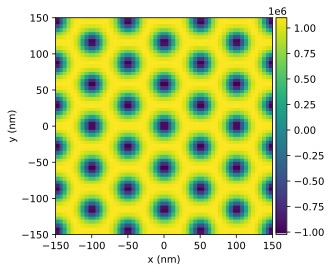

In [4]:
Ms = 1.1e6  # A/m
region = df.Region(p1=(-150e-9, -150e-9, -150e-9), p2=(150e-9, 150e-9, 150e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9), bc='xyz')

def triple_q(pos):
    q = 2*np.pi/(50e-9)
    x, y, z = pos

    m_x = 1*(np.sqrt(3)/3)*(- (np.sqrt(3)/2)*np.sin(q*(-0.5*x+np.sqrt(3)*y/2)) 
                            + (np.sqrt(3)/2)*np.sin(q*(-0.5*x-np.sqrt(3)*y/2)))
    m_y = 1*(np.sqrt(3)/3)*(np.sin(q*(x)) 
                            - (1/2)*np.sin(q*(-0.5*x+np.sqrt(3)*y/2)) 
                            - (1/2)*np.sin(q*(-0.5*x-np.sqrt(3)*y/2)) )
    m_z = (1+ 1*(np.sqrt(3)/3)*(-np.cos(q*(x))
                                - np.cos(q*(-0.5*x+np.sqrt(3)*y/2))
                                - np.cos(q*(-0.5*x-np.sqrt(3)*y/2))))
    return (m_x, m_y, m_z)

system.m = df.Field(mesh, dim=3, value=triple_q, norm=Ms)
system.m.plane('z').z.mpl()

Minimise the energy

Running OOMMF (ExeOOMMFRunner)[2022/07/15 19:18]... (3.1 s)


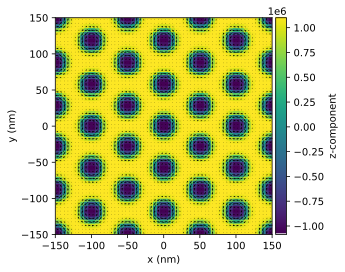

In [5]:
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

fig, ax = plt.subplots()
system.m.plane('x').orientation.z.mpl.scalar(ax=ax, cmap='coolwarm', colorbar_label=r'$M_z$ (Ms)', interpolation='spline16', clim=(-1,1))
plt.savefig('sans_mag_x.png')

Short functions to plot the SANS patterns.

In [8]:
plt.style.use('default')
def plot_sans():
    #plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(1, 3, figsize=(11.7,2.7))
    cross_section.plane(z=0).mpl.scalar(
        ax=ax[0],
        cmap="gray",
        colorbar_label=r"Intensity",
        norm=colors.LogNorm(vmin=1e1, vmax=cross_section.plane(z=0).array.max(), clip=True),
        interpolation='gaussian',
        colorbar=False
    )
    cross_section.plane(x=0).mpl.scalar(
        ax=ax[1],
        cmap="gray",
        colorbar_label=r"Intensity",
        norm=colors.LogNorm(vmin=1e1, vmax=cross_section.plane(x=0).array.max(), clip=True),
        interpolation='gaussian',
        colorbar=False
    )
    im = cross_section_pn.plane(z=0).mpl.scalar(
        ax=ax[2],
        cmap="gray",
        colorbar_label=r"Intensity (arb.)",
        norm=colors.LogNorm(vmin=1e1, vmax=cross_section.plane(z=0).array.max(), clip=True),
        interpolation='gaussian'
    )
    
    ax[0].text(-96, 70, 'a', fontdict={'color': 'w', 'size': 20, 'weight': 'bold'})
    ax[1].text(-96, 70, 'b', fontdict={'color': 'w', 'size': 20, 'weight': 'bold'})
    ax[2].text(-96, 70, 'c', fontdict={'color': 'w', 'size': 20, 'weight': 'bold'})

Calculate the SANS cross sections.

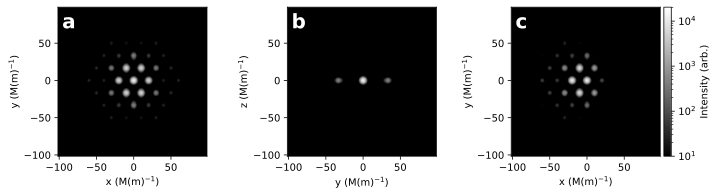

In [9]:
cross_section = mag2exp.sans.cross_section(system.m, method='unpol', polarisation=(0,0,1))
cross_section_pn = mag2exp.sans.cross_section(system.m, method='pn', polarisation=(1,0,0))
plot_sans()

Calculate the chiral function.

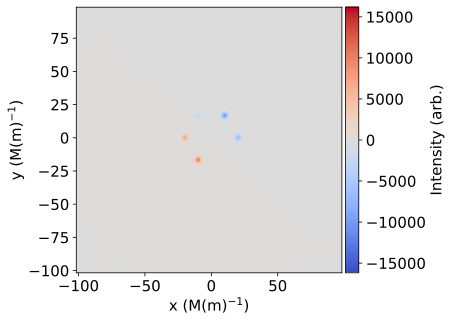

In [15]:
cf = mag2exp.sans.chiral_function(system.m, polarisation=(1,1,0))
cf.plane(z=0).mpl.scalar(cmap="coolwarm",
                         colorbar_label=r"Intensity (arb.)",
                         interpolation='gaussian')